In [9]:
# Imports
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [ ]:
# Step 2: Define paths to train and val folders
data_dir = r'C:\Users\Sachin Maurya\Downloads\archive (3)\archive (6)'  
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Define transforms for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # For grayscale-like normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

# Load datasets using ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val'])
}

# Wrap them in DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
}

# Get class names
class_names = image_datasets['train'].classes
print("Classes:", class_names)


Classes: ['fractured', 'not fractured']


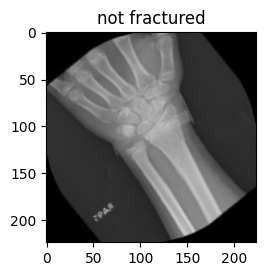

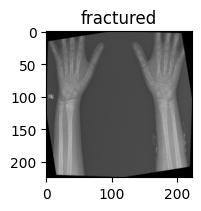

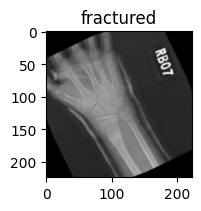

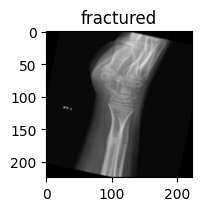

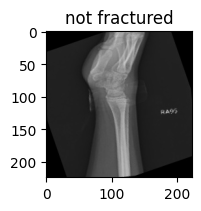

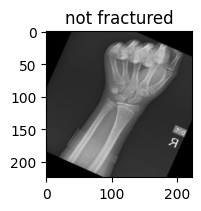

<Figure size 640x480 with 0 Axes>

In [11]:
# Helper function to unnormalize and show image
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp * 0.5 + 0.5  # unnormalize
    plt.imshow(inp.squeeze(), cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Visualize a batch
inputs, classes = next(iter(dataloaders['train']))
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow(inputs[i], title=class_names[classes[i]])
plt.tight_layout()


In [12]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN architecture
class FractureClassifier(nn.Module):
    def __init__(self):
        super(FractureClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input has 3 channels (RGB)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust based on input size (224x224)
        self.fc2 = nn.Linear(128, 2)  # 2 output classes: fractured, not fractured

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (N, 16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 32, 56, 56)
        x = x.view(-1, 32 * 56 * 56)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and move model to device
model = FractureClassifier().to(device)
print(model)


FractureClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [13]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Step 4: Training and Validation Loop
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backprop and optimize only in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute epoch metrics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase.upper()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    return model


In [15]:
# Train the model
model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=20)



🔁 Epoch 1/20
------------------------------
TRAIN Loss: 0.5493 | Acc: 0.7099
VAL Loss: 0.4507 | Acc: 0.7783

🔁 Epoch 2/20
------------------------------
TRAIN Loss: 0.1882 | Acc: 0.9270
VAL Loss: 0.3981 | Acc: 0.8817

🔁 Epoch 3/20
------------------------------
TRAIN Loss: 0.0561 | Acc: 0.9817
VAL Loss: 0.8777 | Acc: 0.8133

🔁 Epoch 4/20
------------------------------
TRAIN Loss: 0.0322 | Acc: 0.9892
VAL Loss: 0.4015 | Acc: 0.8717

🔁 Epoch 5/20
------------------------------
TRAIN Loss: 0.0158 | Acc: 0.9958
VAL Loss: 0.5282 | Acc: 0.8550

🔁 Epoch 6/20
------------------------------
TRAIN Loss: 0.0131 | Acc: 0.9955
VAL Loss: 0.8918 | Acc: 0.8467

🔁 Epoch 7/20
------------------------------
TRAIN Loss: 0.0095 | Acc: 0.9976
VAL Loss: 0.4802 | Acc: 0.8633

🔁 Epoch 8/20
------------------------------
TRAIN Loss: 0.0048 | Acc: 0.9983
VAL Loss: 0.8089 | Acc: 0.8367

🔁 Epoch 9/20
------------------------------
TRAIN Loss: 0.0187 | Acc: 0.9931
VAL Loss: 0.9144 | Acc: 0.8300

🔁 Epoch 10/20
----


📄 Classification Report:

               precision    recall  f1-score   support

    fractured       0.86      0.92      0.89       360
not fractured       0.86      0.78      0.82       240

     accuracy                           0.86       600
    macro avg       0.86      0.85      0.85       600
 weighted avg       0.86      0.86      0.86       600



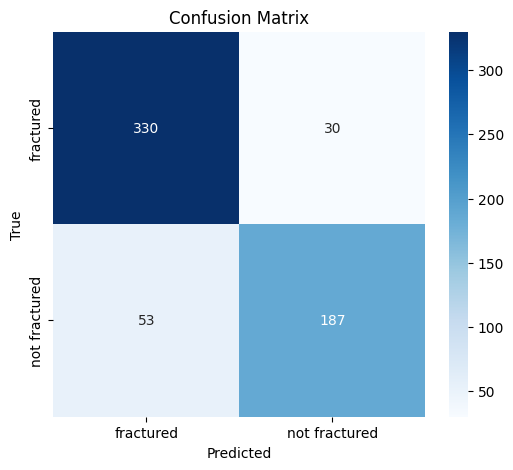

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print classification report
    print("\n📄 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on validation set
evaluate_model(model, dataloaders['val'], class_names)


In [17]:
# Save final trained model weights
torch.save(model.state_dict(), "final_fracture_model.pth")
print("✅ Model saved successfully as 'final_fracture_model.pth'")


✅ Model saved successfully as 'final_fracture_model.pth'
